# Brain MRI scans classifier

This project is inteded to classify the brain mri as bold or t1w images. 
The dataset is taken from the openfmri https://openfmri.org/dataset/ds000243/ . These 120 MRI datasets are being released to the public along as part of the materials for “Temporal interpolation alters motion in fMRI scans: magnitudes and consequences for artifact detection” by Power et al. in PLOS ONE.

Included for each subject is a T1-weighted anatomical image (MP-RAGE) and one or more T2*-weighted scans (resting state BOLD scans)

All subjects 
    - were “typical” young adults that reported no significant neurological or psychiatric history
    - were right-handed and reported that English was their first language
    - were scanned at Washington University in Saint Louis on a Siemens MAGNETOM Tim Trio 3T scanner with a Siemens 12-channel head coil
    - were scanned using interleaved ascending product sequences for T2* data
    - were scanned in the eyes-open resting state fixating a white crosshair on a black background

The data have been described in multiple publications from the Petersen/Schlaggar group,
    - beginning with Power et al., 2013 “Evidence for hubs in human brain networks” in Neuron
    - and most comprehensively in Power et al., 2014 “Methods to detect, characterize, and remove motion artifact in resting state fMRI” in Neuroimage
    - as well as several other publications

## Steps for making the model

    - Preprocessing the data
    - Making a deep neural network and feeding the data to it
    - Training the model
    - Making a model.py file that would use the new inputs and predict the desired label

## 1) Preprocessing the data

The dataset we have is a 3D cube of the subject's MRI images and for bold images these are also 4D image where the 4th dimension is the time. Every subject was split into slices of images. Then these slices were coupled with the respective label and made a new .npy file that stores the images and its label as array 

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

IMG_PX_SIZE = 80
HM_SLICES = 16

data_dir = 'C:/users/setcodestofire/documents/mygithub/brain/FinalData'
dataset  = os.listdir(data_dir)

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

def process_data(data):
    
    path = data_dir +'/'+ data
    img3d = nib.load(path)
    a = np.array(img3d.get_data())
    
    slice_img=[]
    
    if "bold" not in data:
        label = [0,1]
        for i in range(a.shape[2]):
            slice_img.append(cv2.resize(np.array(a[:,:,i]),(IMG_PX_SIZE,IMG_PX_SIZE)))    
    else:
        label = [1,0]  
        for i in range(a.shape[2]):
            slice_img.append(cv2.resize(np.array(a[:,:,i,0]),(IMG_PX_SIZE,IMG_PX_SIZE)))
    
    
    new_slices = []
    
    chunk_sizes = math.ceil(len(slice_img) / HM_SLICES)
    for slice_chunk in chunks(slice_img, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    return np.array(new_slices),np.array(label)

In [ ]:
much_data = []

for data in dataset:
    img_data,label = process_data(data)
    for j in range(16):
        much_data.append([img_data[j],label])

np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE,IMG_PX_SIZE,HM_SLICES), much_data)

## 2) Making the model

Here we are making a deep neural network that will train on the processed data. The network includes 4 hidden layer and one fully connected layer 

In [1]:
import numpy as np

IMG_PX_SIZE = 80
HM_SLICES = 16
LR = 1e-3

MODEL_NAME = 'boldvst1w-{}-{}.model.tflearn'.format(LR, '2conv')


In [2]:
train_data = np.load('muchdata-80-80-16.npy')

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None,IMG_PX_SIZE,IMG_PX_SIZE,1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet,2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet,2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet,2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet,2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR,loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


## Train test data split

In [3]:
train = train_data[:-400]
test = train_data[-400:]

In [4]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_PX_SIZE,IMG_PX_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_PX_SIZE,IMG_PX_SIZE, 1)
test_y = [i[1] for i in test]

## 3) Training the model

In [5]:
model.fit({'input':X},{'targets': Y}, n_epoch=3, validation_set=({'input':test_x},{'targets':test_y}),
         snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 161  | total loss: 0.10928 | time: 123.389s
| Adam | epoch: 003 | loss: 0.10928 - acc: 0.9940 -- iter: 3392/3440
Training Step: 162  | total loss: 0.09844 | time: 130.018s
| Adam | epoch: 003 | loss: 0.09844 - acc: 0.9946 | val_loss: 0.00000 - val_acc: 1.0000 -- iter: 3440/3440
--


In [7]:
model.save('model.tflearn')

INFO:tensorflow:C:\Users\setCodesToFire\Documents\MyGithub\Brain\model.tflearn is not in all_model_checkpoint_paths. Manually adding it.


Model accuracy reached 99.46%

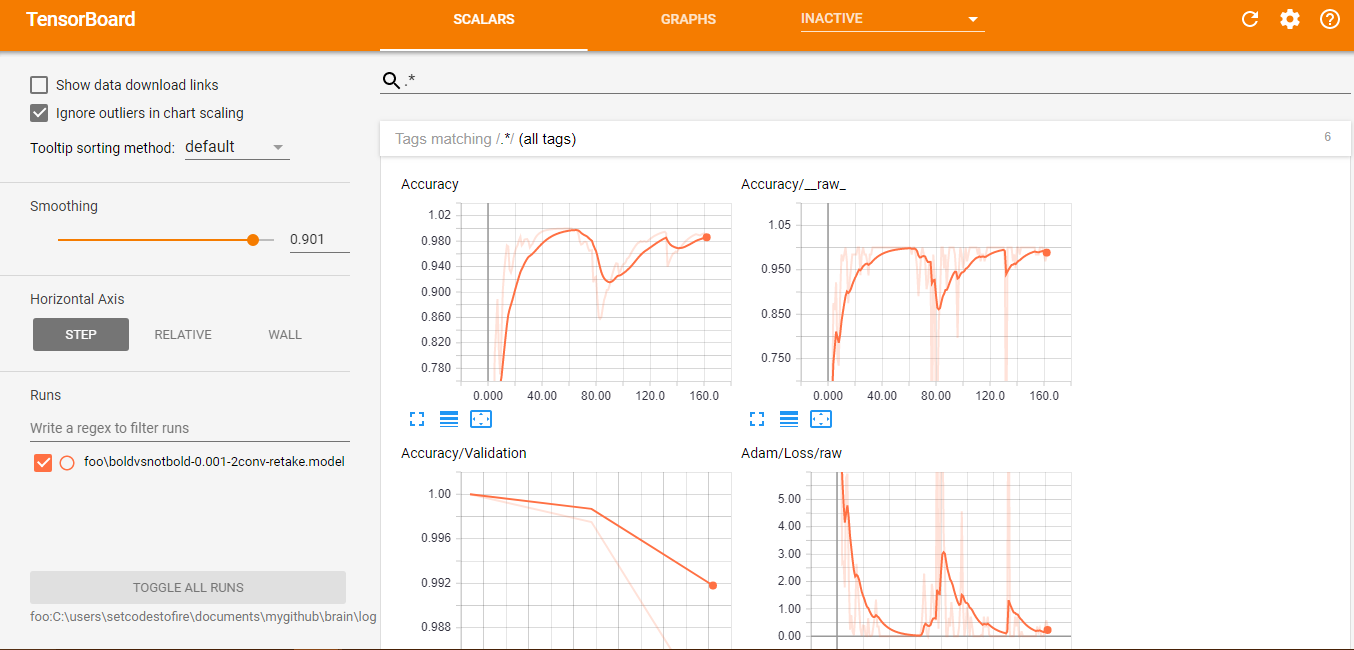